# KOH2: Sieć Kohonena na siatce sześciokątnej
Adrianna Grudzień

-> kodu nie przesyłać, tylko sprawozdanie do 20 maja do godz. 22

-> Sprawko: mają być wykonane wszystkie eksperymenty! + wnioski

Wizualizacje:
- wagi w przestrzeni 2d (wikipedia)
- albo po prostu metryki do sprawdzenia skuteczności

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score

In [61]:
class Koh:
    def __init__(self, k, N, M, theta_fun='gauss', topology='rectangle'):
        self.k = k
        self.N = N
        self.M = M
        self.theta_fun = theta_fun
        self.topology = topology
        self.weights = np.random.uniform(-5,5,size=[self.k, self.N*self.M])
        self._initialize_positions()
        self.accuracy = []
        
    def _initialize_positions(self):
        if self.topology=='rectangle':
            self.positions = np.matrix([(i,j) for i in range(self.N) for j in range(self.M)])
        elif self.topology=='hexagon':
            self.positions = np.matrix([[i+0.5,j] if j%2==0 else (i,j) for i in range(self.N) for j in range(self.M)])
        
    @staticmethod
    def d(w_array,x_array):
        """Odległość euklidesowa (metryka)"""
        return np.linalg.norm(w_array-x_array)
    @staticmethod
    def distance(n1, n2):
        """Odległość między neuronami"""
        return np.abs(n1[0]-n2[0]) + np.abs(n1[1]-n2[1])
    @staticmethod
    def gauss_fun(x, t):
        """Funkcja Gaussa"""
        return np.exp(-np.square(x))
    @staticmethod
    def mexico_fun(x, t):
        """Meksykański kapelusz (-druga pochodna gauss_fun) przeskalowana do [0,1], czyli (f+1)/3"""
        return (2-4*np.square(x))*np.exp(-np.square(x) + 1) / 3 / 10
    def theta(self,n1,n2, t, width):
        """Waga sąsiedztwa wygaszana w czasie
        width - szerokość sąsiedztwa [0.1, 1]
        """
        if self.theta_fun == 'gauss':
            return Koh.gauss_fun(Koh.distance(n1,n2)*width, t)
        elif self.theta_fun == 'mexico':
            return Koh.mexico_fun(Koh.distance(n1,n2)*width, t)
    
    def alpha(self, t):
        """Wygaszanie w czasie"""
        return np.exp(-t/self.n_epochs)
    
    def draw_neurons(self, df):
        """df - ramka obserwacji wraz z kategoriami"""
        positions_x = self.positions[:,0] # położenia na OX neuronów
        positions_y = self.positions[:,1]
        
        # predicted_categories = []
        # for x in np.array(pd.DataFrame(df).iloc[:,:-1]):
        #     predicted_categories.append(self.predict_category(x))

        w = [] #jakaś miara wag 
        for i in range(self.weights.shape[1]):
            w.append(np.sum(self.weights[:,i])/10)
            
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.title('Neurons with summed weights')
        plt.scatter(np.array(positions_x.T), np.array(positions_y.T), s=np.array(w), alpha=0.3)
        plt.show()
    
    
    def find_the_nearest_neuron(self, x):
        """Znajdź neuron najbliższy obserwacji x"""
        distances = []
        for i in range(self.weights.shape[1]):
            distances.append(Koh.d(self.weights[:,i], x))
        return self.weights[:, np.argmin(distances)]
    
    def find_the_nearest_neuron_position(self, x):
        """Znajdź neuron najbliższy obserwacji x"""
        distances = []
        for i in range(self.weights.shape[1]):
            distances.append(Koh.d(self.weights[:,i], x))
        return self.positions[np.argmin(distances),:]
            
    def train(self, df=None, n_epochs=10, graph_period=2, width=1):
        """
        data - ramka danych wraz z kategorią (x,y,c)
        width - szerokość sąsiedztwa [0.1, 1]
        """
        self.n_epochs = n_epochs

        print('Random weights')
        # self.draw_neurons(df)
        for t in range(n_epochs):
            np.random.shuffle(df)
            data = np.array(pd.DataFrame(df).iloc[:,:-1])
            for x in data:
                w_min = self.find_the_nearest_neuron(x)
                [i_min, j_min] = np.array(self.find_the_nearest_neuron_position(x))[0]
            
                for neuron_num in range(self.weights.shape[1]):
                    self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
            
            predicted_categories = []
            for x in np.array(pd.DataFrame(df).iloc[:,:-1]):
                predicted_categories.append(self.predict_category(x))
            self.accuracy.append(adjusted_rand_score(df[:,-1], predicted_categories))
            
            
            if t%graph_period==0:
                print('Number of epoch: ', t)
                # self.draw_neurons(df)
                    
    def predict_category(self, x):
        """Przewidź kategorię jednej obserwacji"""
        distances = []
        for i in range(self.weights.shape[1]):
            distances.append(Koh.d(self.weights[:,i], x))
        return int(np.argmin(distances))

## Pobranie zbioru `MNIST`

In [3]:
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data_with_c = np.loadtxt('./data/mnist_train.csv', 
                        delimiter=",")

In [4]:
train_data_with_c.shape # obrazki są domyślnie spłaszczone

(60000, 785)

In [5]:
classes = train_data_with_c[:,0]
train_data = train_data_with_c[:,1:]

In [6]:
train_data.shape

(60000, 784)

In [14]:
# wyrzucenie kolumny z klasami do ostatniej kolumny
train_data = pd.DataFrame(train_data)
train_data[784] = classes
train_data_with_c = train_data
train_data_with_c.shape

(60000, 785)

In [8]:
# print('Class: ', int(classes[0]))
# plt.imshow(np.reshape(train_data[0], (28,28)))
# plt.show()

## Siatka 12x12

### Siatka prostokątna

## gauss

In [9]:
koh = Koh(k=784, N=6, M=6, theta_fun='gauss', topology='rectangle')
koh.train(df=np.array(train_data_with_c)[:400,:], n_epochs=1000, graph_period=600)

Random weights
Number of epoch:  0
Number of epoch:  600


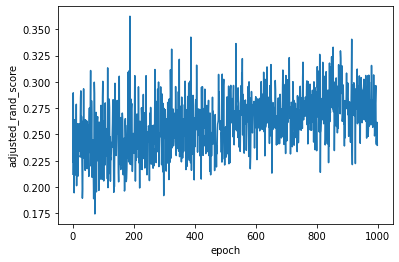

In [10]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

## mexico

In [11]:
koh = Koh(k=784, N=12, M=12, theta_fun='mexico', topology='rectangle')
koh.train(df=np.array(train_data_with_c)[:400,:], n_epochs=1000, graph_period=600)

Random weights
Number of epoch:  0


/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_47140/1902381683.py:9

Number of epoch:  600


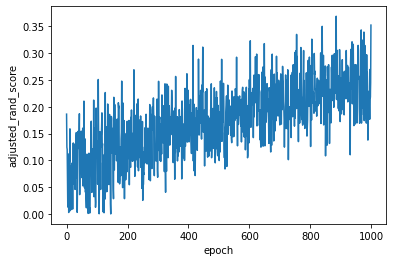

In [12]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

### Siatka sześciokątna

In [13]:
koh = Koh(k=784, N=12, M=12, theta_fun='gauss', topology='hexagon')
koh.train(df=np.array(train_data_with_c)[:400,:], n_epochs=1000, graph_period=600)

Random weights
Number of epoch:  0
Number of epoch:  600


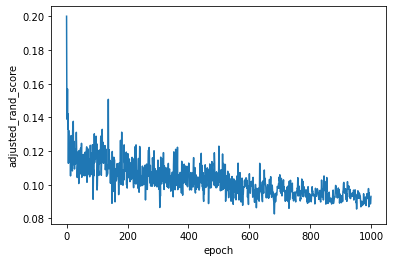

In [14]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

## Siatka 28x28

### Siatka prostokątna

In [15]:
koh = Koh(k=784, N=28, M=28, theta_fun='gauss', topology='rectangle')
koh.train(df=np.array(train_data_with_c)[:400,:], n_epochs=1000, graph_period=600)

Random weights
Number of epoch:  0
Number of epoch:  600


KeyboardInterrupt: 

### Siatka sześciokątna

In [ ]:
koh = Koh(k=784, N=28, M=28, theta_fun='gauss', topology='hexagon')
koh.train(df=np.array(train_data_with_c[:400,:]), n_epochs=1000, graph_period=600)

In [21]:
koh = Koh(k=784, N=5, M=2, theta_fun='mexico', topology='rectangle')
koh.train(df=np.array(train_data_with_c)[:400,:], n_epochs=1000, graph_period=600)

Random weights
Number of epoch:  0


/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_47140/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])


Number of epoch:  600


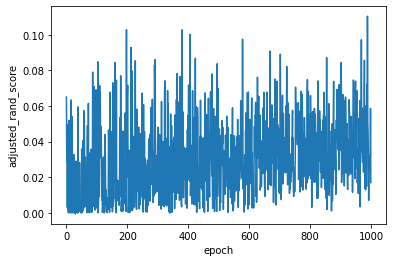

In [22]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

In [15]:
koh = Koh(k=784, N=5, M=2, theta_fun='mexico', topology='hexagon')
koh.train(df=np.array(train_data_with_c)[:400,:], n_epochs=100, graph_period=600)

Random weights
Number of epoch:  0


/tmp/ipykernel_52877/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_52877/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_52877/1902381683.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])


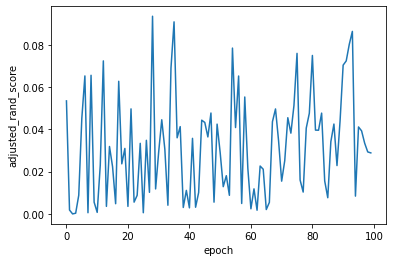

In [17]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

# Zbiór UCI

In [18]:
df = pd.read_fwf('./data/UCI HAR Dataset/train/X_train.txt', header=None)

In [19]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [20]:
df.shape

(7352, 561)

In [ ]:
# df[561] = np.zeros((df.shape[0],1)) # sztuczne generowanie kategorii, zupełnie niepotrzebne, ale być może algorytm tego wymaga

In [21]:
true_labels = pd.read_fwf('./data/UCI HAR Dataset/train/y_train.txt', header=None)

In [23]:
true_labels.head()

,0
0,5
1,5
2,5
3,5
4,5


In [24]:
df_with_c = df.copy(deep=True)
df_with_c[561] = true_labels
df_with_c.shape

(7352, 562)

In [34]:
koh = Koh(k=561, N=3, M=2, theta_fun='gauss', topology='rectangle')
koh.train(df=np.array(np.matrix(df_with_c)[:400,:]), n_epochs=1010, graph_period=500)

Random weights
Number of epoch:  0
Number of epoch:  500
Number of epoch:  1000


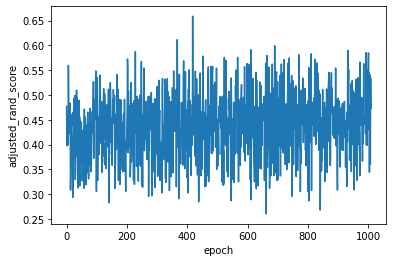

In [35]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

In [40]:
koh = Koh(k=561, N=3, M=2, theta_fun='gauss', topology='hexagon')
koh.train(df=np.array(np.matrix(df_with_c)[:400,:]), n_epochs=1010, graph_period=500)

Random weights
Number of epoch:  0
Number of epoch:  500
Number of epoch:  1000


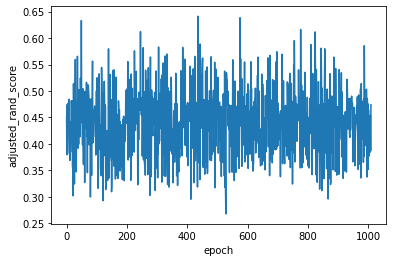

In [41]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

In [62]:
koh = Koh(k=561, N=3, M=2, theta_fun='mexico', topology='rectangle')
koh.train(df=np.array(np.matrix(df_with_c)[:400,:]), n_epochs=50, graph_period=500)

Random weights
Number of epoch:  0


/tmp/ipykernel_52877/4186132680.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
/tmp/ipykernel_52877/4186132680.py:98: RuntimeWarning: overflow encountered in add
  self.weights[:,neuron_num] += self.theta([i_min,j_min], np.array(self.positions[neuron_num,:])[0], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])


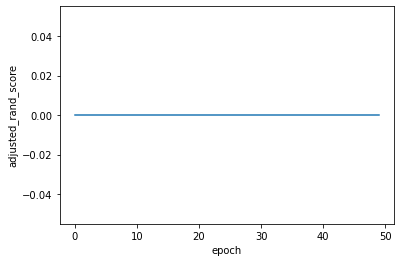

In [63]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()

In [66]:
accuracy

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [64]:
koh = Koh(k=561, N=3, M=2, theta_fun='mexico', topology='hexagon')
koh.train(df=np.array(np.matrix(df_with_c)[:400,:]), n_epochs=10, graph_period=500)

Random weights
Number of epoch:  0


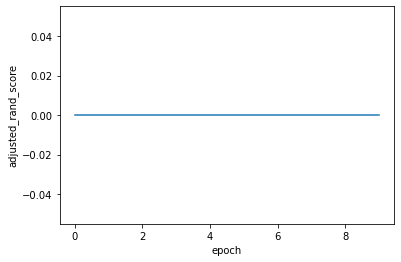

In [65]:
accuracy = koh.accuracy
plt.plot(range(len(accuracy)), accuracy)
plt.ylabel('adjusted_rand_score')
plt.xlabel('epoch')
plt.show()